In [21]:
from collections import defaultdict, Counter
import pandas as pd
from nltk import ngrams
import spacy
from matplotlib import pyplot as plt
%matplotlib notebook

In [3]:
#!python -m spacy download en
_spacy = spacy.load("en_core_web_sm")

In [4]:
_df = pd.concat([
    pd.read_csv('/Users/mario/code/pb_speaker_adaptation/src/analysis/28sept/adaptive_speak_test_out_domain_appliances.csv', error_bad_lines=False, warn_bad_lines=True),
    pd.read_csv('/Users/mario/code/pb_speaker_adaptation/src/analysis/28sept/adaptive_speak_test_out_domain_food.csv', error_bad_lines=False, warn_bad_lines=True),
    pd.read_csv('/Users/mario/code/pb_speaker_adaptation/src/analysis/28sept/adaptive_speak_test_out_domain_indoor.csv', error_bad_lines=False, warn_bad_lines=True),
    pd.read_csv('/Users/mario/code/pb_speaker_adaptation/src/analysis/28sept/adaptive_speak_test_out_domain_outdoor.csv', error_bad_lines=False, warn_bad_lines=True),
    pd.read_csv('/Users/mario/code/pb_speaker_adaptation/src/analysis/28sept/adaptive_speak_test_out_domain_vehicles.csv', error_bad_lines=False, warn_bad_lines=True)
])

# pd.to_numeric(df['target domain'], errors='coerce')

print('target domain   :', _df['target domain'].unique())
print('listener domain :', _df['listener domain'].unique())
print('simulator domain:', _df['interpreter domain'].unique())
_df = _df.dropna()
print('Data points:', len(_df))

df = _df[_df['target domain'] != _df['listener domain']]
df = df[df['listener domain'] != 'all']
df = df[df['interpreter domain'] != 'all']
print('OOD data points:', len(df))

df.head(2)

/var/folders/0s/847v13g104z23kr193w_v2640000gn/T/ipykernel_16518/3096090768.py:2: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  pd.read_csv('/Users/mario/code/pb_speaker_adaptation/src/analysis/28sept/adaptive_speak_test_out_domain_appliances.csv', error_bad_lines=False, warn_bad_lines=False),
/var/folders/0s/847v13g104z23kr193w_v2640000gn/T/ipykernel_16518/3096090768.py:2: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  pd.read_csv('/Users/mario/code/pb_speaker_adaptation/src/analysis/28sept/adaptive_speak_test_out_domain_appliances.csv', error_bad_lines=False, warn_bad_lines=False),
/var/folders/0s/847v13g104z23kr193w_v2640000gn/T/ipykernel_16518/3096090768.py:2: DtypeWarning: Columns (54,55,56,64,65,66) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv('/Users/m

target domain   : ['food' 'vehicles' 'outdoor' 'indoor' 'appliances']
listener domain : ['indoor' 'appliances' 'food' 'outdoor' 'vehicles']
simulator domain: ['indoor' 'appliances' 'food' 'outdoor' 'vehicles']
Data points: 5817
OOD data points: 4758


,Unnamed: 0,target domain,listener domain,interpreter domain,target img idx,img path #0,img path #1,img path #2,img path #3,img path #4,...,int_list_acc10,int_list_acc11,int_list_acc12,int_list_acc13,int_list_acc14,int_list_acc15,int_list_acc16,int_list_acc17,int_list_acc18,int_list_acc19
2,2,food,indoor,indoor,0,/home/brandizzi/pb_speaker_adaptation/dataset/...,/home/brandizzi/pb_speaker_adaptation/dataset/...,/home/brandizzi/pb_speaker_adaptation/dataset/...,/home/brandizzi/pb_speaker_adaptation/dataset/...,/home/brandizzi/pb_speaker_adaptation/dataset/...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,5,food,indoor,indoor,2,/home/brandizzi/pb_speaker_adaptation/dataset/...,/home/brandizzi/pb_speaker_adaptation/dataset/...,/home/brandizzi/pb_speaker_adaptation/dataset/...,/home/brandizzi/pb_speaker_adaptation/dataset/...,/home/brandizzi/pb_speaker_adaptation/dataset/...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
N_STEPS = 20

refs = df['golden utt'].tolist()

hyps = {"h0": df['original utt'].tolist()}
hyps.update(
    {f"h0 {s}": df[f"adapted utt s{s}"].tolist() for s in range(N_STEPS)}
)
hyps.keys()

dict_keys(['h0', 'h0 0', 'h0 1', 'h0 2', 'h0 3', 'h0 4', 'h0 5', 'h0 6', 'h0 7', 'h0 8', 'h0 9', 'h0 10', 'h0 11', 'h0 12', 'h0 13', 'h0 14', 'h0 15', 'h0 16', 'h0 17', 'h0 18', 'h0 19'])

In [6]:
pos = defaultdict(lambda: defaultdict(lambda: Counter()))

for ref in refs:
    pos_seq = [tok.pos_ for tok in _spacy(ref)]
    for N in range(1, 2):
        for ngram in ngrams(pos_seq, N):
            pos[N]['ref'][ngram] += 1        
            
for hyp_type in hyps:
    for hyp in hyps[hyp_type]:
        pos_seq = [tok.pos_ for tok in _spacy(hyp)]
        for N in range(1, 2):
            for ngram in ngrams(pos_seq, N):
                pos[N][hyp_type][ngram] += 1
                
for hyp_type in ['ref'] + list(hyps.keys()):
    for N in range(1, 2):
        tot = sum(pos[N][hyp_type].values())
        for k, v in pos[N][hyp_type].items():
            pos[N][hyp_type][k] = v / tot


In [7]:
pos_df_1 = pd.DataFrame(pos[1].values(), index=pos[1].keys())
# pos_df_2 = pd.DataFrame(pos[2].values(), index=pos[2].keys())
# pos_df_3 = pd.DataFrame(pos[3].values(), index=pos[3].keys())

<IPython.core.display.Javascript object>


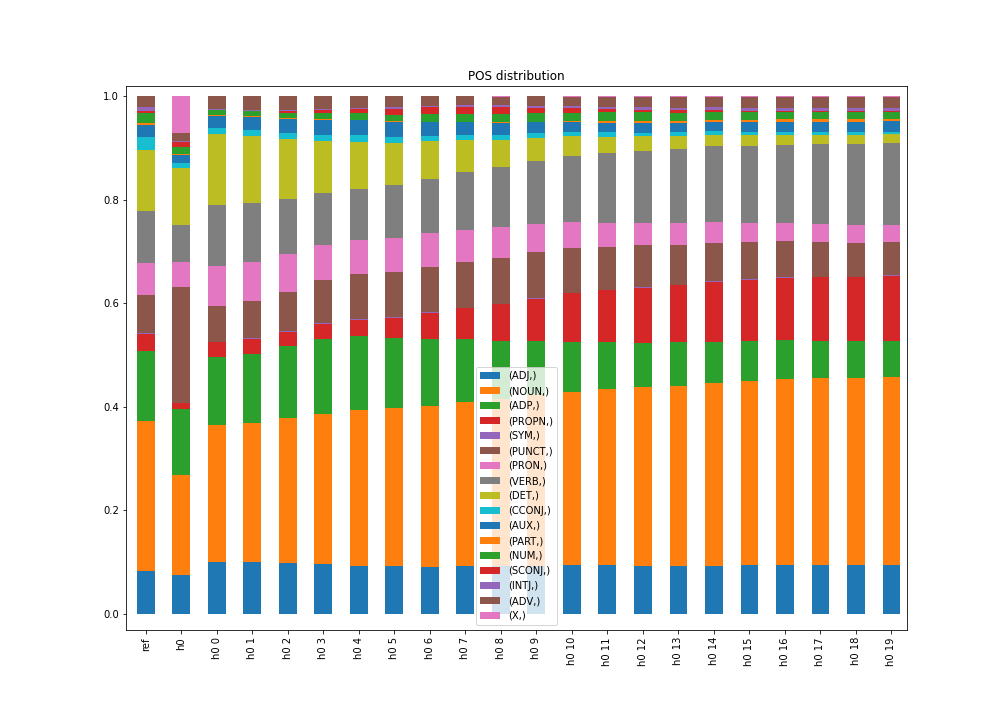

Text(0.5, 1.0, 'POS distribution')

In [23]:
pos_df_1.plot(kind='bar', stacked=True, figsize=(14,10))
plt.title('POS distribution')
